<a href="https://colab.research.google.com/github/tomashphill/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/BW2_Model_Making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
paintings = pd.read_csv('paintings.csv', index_col=0)

In [ ]:
paintings.head()

,Title,Artist,Date,Classification,Height,Width,1h,2h,3h,4h,5h,6h,1s,2s,3s,4s,1v,2v,3v,4v,ThumbnailURL,Period,Color_Distribution_Score,Contrast_Score,Saturation_Contrast_Score,SatCon,American?,Male_Artist?,Title?,Lightness,Saturation
0,The Factory and the Bridge,Olga Rozanova,1913,Painting,83.2,61.6,0.59,0.04,0.03,0.24,0.06,0.04,0.77,0.21,0.02,0.0,0.19,0.48,0.31,0.02,http://www.moma.org/media/W1siZiIsIjIzMzkwNSJd...,Modern,0.71,0.56,0.45,0.505,False,False,True,0.386667,0.083333
1,Non-Objective Painting,Aleksandr Rodchenko,1919,Painting,84.5,71.1,1.00,0.00,0.00,0.00,0.00,0.00,0.01,0.41,0.58,0.0,0.01,0.93,0.06,0.00,http://www.moma.org/media/W1siZiIsIjQwMDg1MiJd...,Modern,0.00,0.10,0.39,0.245,False,True,True,0.350000,0.523333
2,Non-Objective Painting no. 80 (Black on Black),Aleksandr Rodchenko,1918,Painting,81.9,79.4,0.87,0.02,0.02,0.07,0.00,0.02,1.00,0.00,0.00,0.0,0.77,0.20,0.02,0.00,http://www.moma.org/media/W1siZiIsIjI5MjM2MSJd...,Modern,0.28,0.42,0.00,0.210,False,True,True,0.076667,0.000000
3,"Landscape, 47",Natalia Goncharova,1912,Painting,54.6,46.7,0.57,0.05,0.05,0.17,0.08,0.08,0.85,0.14,0.01,0.0,0.58,0.33,0.09,0.00,http://www.moma.org/media/W1siZiIsIjE1NjkiXSxb...,Modern,0.77,0.58,0.33,0.455,False,False,True,0.170000,0.053333
4,"Rayonism, Blue-Green Forest",Natalia Goncharova,1911,Painting,54.6,49.5,0.01,0.02,0.30,0.64,0.02,0.00,0.62,0.38,0.00,0.0,0.39,0.49,0.11,0.01,http://www.moma.org/media/W1siZiIsIjI2MTIyOCJd...,Modern,0.60,0.63,0.61,0.620,False,False,True,0.246667,0.126667


### <font color="darkcyan">Exploratory Visualizations...</font>

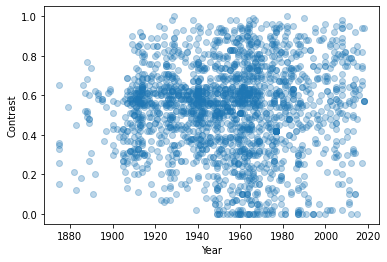

In [ ]:
import matplotlib.pyplot as plt

# Interestingly, paintings with very low contrast start appearing around
# 1950, the point around where "modern" becomes "contemporary"
plt.scatter(paintings['Date'], paintings['Contrast_Score'], alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Contrast');

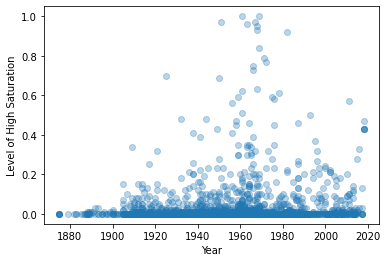

In [ ]:
plt.scatter(paintings['Date'], paintings['4s'], alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Level of High Saturation');

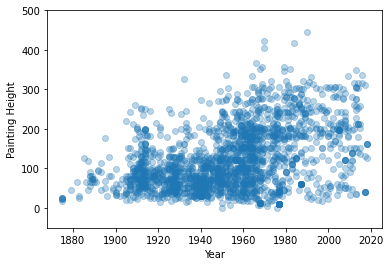

In [ ]:
plt.scatter(paintings['Date'], paintings['Height'], alpha=0.3)
plt.ylim(top=500)
plt.xlabel('Year')
plt.ylabel('Painting Height');

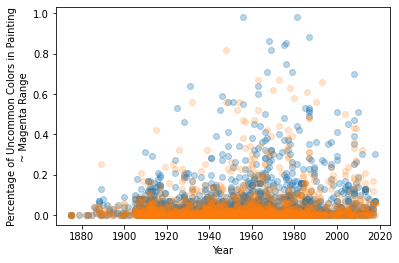

In [ ]:
plt.scatter(paintings['Date'], paintings['6h'], alpha=0.3)
plt.scatter(paintings['Date'], paintings['5h'], alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Percentage of Uncommon Colors in Painting\n~ Magenta Range');

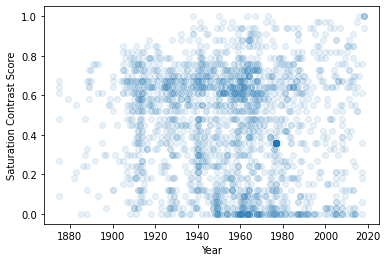

In [ ]:
plt.scatter(paintings['Date'], paintings['Saturation_Contrast_Score'], alpha=0.1)

plt.xlabel('Year')
plt.ylabel('Saturation Contrast Score');

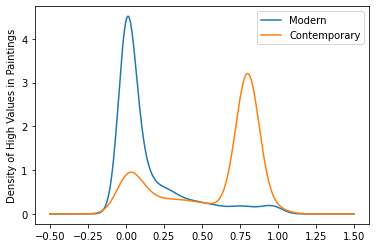

In [ ]:
modern = paintings[paintings['Period'] == 'Modern']
contemp = paintings[paintings['Period'] == 'Contemporary']
modern['4v'].plot(kind='density')
contemp['4v'].plot(kind='density')
plt.ylabel('Density of High Values in Paintings')
plt.legend(labels=['Modern', 'Contemporary']);

# looks like "contemporary" paintings tend to be brighter!

### <font color="darkcyan">Models, Models, Models</font>

In [ ]:
paintings.head()

,Title,Artist,Date,Classification,Height,Width,1h,2h,3h,4h,5h,6h,1s,2s,3s,4s,1v,2v,3v,4v,ThumbnailURL,Period,Color_Distribution_Score,Contrast_Score,Saturation_Contrast_Score,SatCon,American?,Male_Artist?,Title?,Lightness,Saturation
0,The Factory and the Bridge,Olga Rozanova,1913,Painting,83.2,61.6,0.59,0.04,0.03,0.24,0.06,0.04,0.77,0.21,0.02,0.0,0.19,0.48,0.31,0.02,http://www.moma.org/media/W1siZiIsIjIzMzkwNSJd...,Modern,0.71,0.56,0.45,0.505,False,False,True,0.386667,0.083333
1,Non-Objective Painting,Aleksandr Rodchenko,1919,Painting,84.5,71.1,1.00,0.00,0.00,0.00,0.00,0.00,0.01,0.41,0.58,0.0,0.01,0.93,0.06,0.00,http://www.moma.org/media/W1siZiIsIjQwMDg1MiJd...,Modern,0.00,0.10,0.39,0.245,False,True,True,0.350000,0.523333
2,Non-Objective Painting no. 80 (Black on Black),Aleksandr Rodchenko,1918,Painting,81.9,79.4,0.87,0.02,0.02,0.07,0.00,0.02,1.00,0.00,0.00,0.0,0.77,0.20,0.02,0.00,http://www.moma.org/media/W1siZiIsIjI5MjM2MSJd...,Modern,0.28,0.42,0.00,0.210,False,True,True,0.076667,0.000000
3,"Landscape, 47",Natalia Goncharova,1912,Painting,54.6,46.7,0.57,0.05,0.05,0.17,0.08,0.08,0.85,0.14,0.01,0.0,0.58,0.33,0.09,0.00,http://www.moma.org/media/W1siZiIsIjE1NjkiXSxb...,Modern,0.77,0.58,0.33,0.455,False,False,True,0.170000,0.053333
4,"Rayonism, Blue-Green Forest",Natalia Goncharova,1911,Painting,54.6,49.5,0.01,0.02,0.30,0.64,0.02,0.00,0.62,0.38,0.00,0.0,0.39,0.49,0.11,0.01,http://www.moma.org/media/W1siZiIsIjI2MTIyOCJd...,Modern,0.60,0.63,0.61,0.620,False,False,True,0.246667,0.126667


In [ ]:
from sklearn.model_selection import train_test_split

# drop leakers and target vector
# SatCon is just a linear combination of 2 features
X = paintings.drop(['Period', 'Date', 'ThumbnailURL',
                    'Classification', 'Title', 'Artist',
                    'SatCon'], axis=1)

# feature engineering
# just combining the separate amounts of light/sat together
paintings['Lightness'] = .25*paintings['1v']    \
                          + .5*paintings['2v']  \
                          + .75*paintings['3v'] \
                          + paintings['4v'] 

paintings['Saturation'] = .25*paintings['1s']   \
                          + .5*paintings['2s']  \
                          + .75*paintings['3s'] \
                          + paintings['4s']

paintings['Lightness'] = paintings['Lightness'] - .25
paintings['Saturation'] = paintings['Saturation'] - .25
paintings['Lightness'] = paintings['Lightness'] * (4 / 3)
paintings['Saturation'] = paintings['Saturation'] * (4 / 3)

X = X.drop(['1s', '2s', '3s', '4s', '1v', '2v', '3v', '4v'], axis=1)

# target vector will be 'Period'
y = paintings['Period']

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size=0.8,
                                                  random_state=19)

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5215669014084507


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# make pipeline
forestPipe = make_pipeline(SimpleImputer(),
                      RandomForestClassifier(max_depth=10, 
                                             n_estimators=80,
                                             random_state=42)
)
                 

forestPipe.fit(X_train, y_train);

print('Training Set Score:', forestPipe.score(X_train, y_train))
print('Validation Set Score:', forestPipe.score(X_val, y_val))

Training Set Score: 0.9700704225352113
Validation Set Score: 0.8661971830985915


In [ ]:
# make a copy so I can compare scores AFTER permutation importance
oldTrainScore = forestPipe.score(X_train, y_train).copy()
oldValScore = forestPipe.score(X_val, y_val).copy()

In [ ]:
!pip install pdpbox

#### <font color="darkcyan">Let's check feature importances...</font>

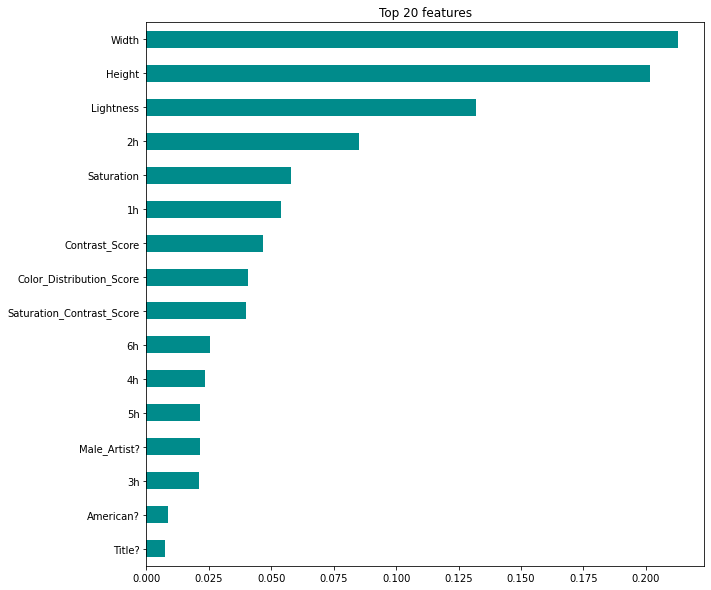

In [ ]:
# get model from pipeline, and feature importances from model
forest = forestPipe.named_steps['randomforestclassifier']
importances = pd.Series(forest.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

# only show 20
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
# [-n:] picks top 20
importances.sort_values()[-n:].plot.barh(color='darkcyan');

#### <font color="darkcyan">Random Forest feature importance might be inflating the importance of continous features. Let's try permutation importance.</font>

In [ ]:
%%capture
# separate the pipeline to make this work
transformer = SimpleImputer()

# transoform data first
Xt_train = transformer.fit_transform(X_train)
Xt_val = transformer.transform(X_val)

# create model with transformed data
model = RandomForestClassifier(max_depth=18, 
                               n_estimators=180,
                               random_state=42)

model.fit(Xt_train, y_train)

In [ ]:
%%capture
!pip install eli5

In [ ]:
%%capture
import eli5
from eli5.sklearn import PermutationImportance

# create a permuter!
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

# fit permuter to data!
permuter.fit(Xt_val, y_val)

In [ ]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0377 ± 0.0168,Lightness
0.0243 ± 0.0198,Height
0.0239 ± 0.0186,Width
0.0106 ± 0.0063,Color_Distribution_Score
0.0074 ± 0.0082,Male_Artist?
0.0067 ± 0.0026,3h
0.0046 ± 0.0073,4h
0.0035 ± 0.0074,Saturation_Contrast_Score
0.0035 ± 0.0102,1h
0.0018 ± 0.0022,Title?


In [ ]:
# let's get rid of values that negatively affect our model!
# meaning, anything that is negative (below 0)

minimum_importance = 0

mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]

# grabs features with importance > 0
X_train_better = X_train[features]
X_val_better = X_val[features]

In [ ]:
forestPipe.fit(X_train_better, y_train);

# improvement!!!
print('Training Set Score:', oldTrainScore)
print('Validation Set Score:', oldValScore)

print('-'*40)

print('Training Set Score:', forestPipe.score(X_train_better, y_train))
print('Validation Set Score:', forestPipe.score(X_val_better, y_val))

Training Set Score: 0.9700704225352113
Validation Set Score: 0.8661971830985915
----------------------------------------
Training Set Score: 0.9691901408450704
Validation Set Score: 0.8767605633802817


In [ ]:
!pip install xgboost

In [ ]:
%%capture
from xgboost import XGBClassifier

# instantiate XGBooster!
xgb = XGBClassifier(
    n_estimators=120, 
    n_jobs=-1,
    max_depth=3,
    learning_rate=0.3
)

# fit!
xgb.fit(Xt_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

# Doesn't seem to do much better than a random forest...
y_train_pred = xgb.predict(Xt_train)
y_val_pred = xgb.predict(Xt_val)

print('Training Accuracy', accuracy_score(y_train, y_train_pred))
print('Validation Accuracy', accuracy_score(y_val, y_val_pred))

Training Accuracy 0.9661091549295775
Validation Accuracy 0.8573943661971831
